In [71]:
#imports
from scipy.spatial import distance_matrix
from random import randrange
import copy
import matplotlib.pyplot as plt
import imageio
import random

In [2]:
#loading datasets 
import numpy as np
kroa={}
krob={}
np_kroa=[]
np_krob=[]
with open('kroa100.txt') as f:
    lines = f.readlines()
    for line in lines[6:-1]:
        x=list(map(int,line.strip().split(' ')))
        #print(x)
        kroa[x[0]]=(x[1],x[2])
        np_kroa.append((x[1],x[2]))
np_kroa=np.array(np_kroa)
with open('krob100.txt') as f:
    lines = f.readlines()
    for line in lines[6:-1]:
        x=list(map(int,line.strip().split(' ')))
        #print(x)
        krob[x[0]]=(x[1],x[2])
        np_krob.append((x[1],x[2]))

np_kroa=np.array(np_kroa)
np_krob=np.array(np_krob)

#calculating distance matrix - https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance_matrix.html
dista=distance_matrix(np_kroa,np_kroa)
distb=distance_matrix(np_krob,np_krob)

In [90]:
#plotting functions
def plotResult(np_dots, cycles):
    plt.plot(np_dots[:,0][cycles[0][0]], np_dots[:,1][cycles[0][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[1][0]], np_dots[:,1][cycles[1][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[0]], np_dots[:,1][cycles[0]], "->")
    plt.plot(np_dots[:,0][cycles[1]], np_dots[:,1][cycles[1]], "->")
    plt.show()
    
def plotPartResult(np_dots, cycles,i=0):
    plt.plot(np_dots[:,0][cycles[0][0]], np_dots[:,1][cycles[0][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[1][0]], np_dots[:,1][cycles[1][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[0]], np_dots[:,1][cycles[0]], "->")
    plt.plot(np_dots[:,0][cycles[1]], np_dots[:,1][cycles[1]], "->")
    plt.plot(np_dots[:,0], np_dots[:,1], ".")
    #plt.savefig(f'plots/{i}.png')
    plt.show()    
    
def calcDistance(currentCycle, dist):
    distance = 0
    for x,y in zip(currentCycle, [*currentCycle[1:], currentCycle[0]]):
        distance += dist[x][y]
    return distance 

In [4]:
# 1st variable - Start cycle - with random assignments
def start_cycle_random(dataset_choice="kroa"):
    if dataset_choice=="kroa":
        dataset=np_kroa
        dic=kroa
        dist=copy.deepcopy(dista)
        dist_stable=copy.deepcopy(dista)
    else:
        dataset=np_krob
        dic=krob
        dist=copy.deepcopy(distb)
        dist_stable=copy.deepcopy(distb)
    candidates=np.arange(0,100,1)
    #print(candidates)
    cycles={}
    cycles[0]=[randrange(100)]
    candidates=np.delete(candidates, cycles[0][0])
    cycles[1]=[(np.argsort(dist[cycles[0][0]])[-2])]
    candidates=np.delete(candidates, cycles[1][0])
    chosenCycle=1
    for i in range(0,98):
        chosenCycle = int((chosenCycle + 1)%2)
        chosenElementIndex = np.random.randint(len(candidates))
        #print(chosenElementIndex,len(candidates),candidates[chosenElementIndex])
        #cycles[chosenCycle]=np.insert(cycles[chosenCycle],candidates[chosenElementIndex])
        cycles[chosenCycle]=np.concatenate((cycles[chosenCycle], [candidates[chosenElementIndex]]), axis=0)
        candidates=np.delete(candidates, chosenElementIndex)
    return cycles


In [5]:
# 1st variable - Start cycle - with nearest neighbour method
def starty_cycle_heuristic(dataset_choice="kroa"):
    results=[]
    min_result=np.inf
    max_result=0
    if dataset_choice=="kroa":
        dataset=np_kroa
        dic=kroa
        dist=copy.deepcopy(dista)
        dist_stable=copy.deepcopy(dista)
    else:
        dataset=np_krob
        dic=krob
        dist=copy.deepcopy(distb)
        dist_stable=copy.deepcopy(distb)


    #zmiana dystansu przekątnej na nieskonczonosc
    np.fill_diagonal(dist, np.inf)

    cycles={}
    cycles[0]=[randrange(100)]
    cycles[1]=[(np.argsort(dist[cycles[0][0]])[-2])]

    for b in range(2):
        dist[:,int(cycles[b][0])]=np.inf

    chosenCycle=1
    for i in range(0,98):
        chosenCycle = int((chosenCycle + 1)%2)
        candidates=[]
        for z,index in enumerate(cycles[chosenCycle]):
            candidates.append((np.argmin(dist[index]),np.min(dist[index]),z))
        candidates=np.array(candidates)
        x=np.argmin(candidates[:,1])
        cycles[chosenCycle]=np.insert(cycles[chosenCycle],int(candidates[x,2]),int(candidates[x,0]))
        dist[:,int(candidates[x,0])]=np.inf
    
    print(f"cycle[0]: {calcDistance(cycles[0], dist_stable)}")
    print(f"cycle[1]: {calcDistance(cycles[1], dist_stable)}")
    
    #SAVING RESULTS 
    results.append(calcDistance(cycles[0],dist_stable)+calcDistance(cycles[1],dist_stable))
    if results[-1]>max_result:
        max_result=results[-1]
    if results[-1]<min_result:
        min_result=results[-1]
        plt.clf()
        plt.plot(dataset[:,0][cycles[0][0]], dataset[:,1][cycles[0][0]], "o", markersize=12)
        plt.plot(dataset[:,0][cycles[1][0]], dataset[:,1][cycles[1][0]], "o", markersize=12)
        plt.plot(dataset[:,0][cycles[0]], dataset[:,1][cycles[0]], "->")
        plt.plot(dataset[:,0][cycles[1]], dataset[:,1][cycles[1]], "->")
        plt.savefig(f'best_NN_{dataset_choice}.png')
    return cycles

In [125]:
# 2nd variable - Find more optimal solution
# switch parameter defines how u find neighbour solutions (is it change_vertices or change_edges func)
def greedy_search(dist, np_dots, init_random = False, switch="change_edges"):
    #specify cycles initialization.
    if init_random:
        cycles = start_cycle_random()
    else:
        cycles = starty_cycle_heuristic()
    
    if switch == "change_vertices":
        internal_change = change_vertices
    elif switch == "change_edges":
        internal_change = change_edges
    else:
        print(f"Unknow mode {switch}. Select change_vertices or change_edges")
        return
    
    bestDistance = 0
    bestDistance += calcDistance(cycles[0], dist) 
    bestDistance += calcDistance(cycles[1], dist) 
    print(f"Initial distance: {bestDistance}")
    
    plotPartResult(np_dots, cycles)
    
    
    done = False
    while not done:
        done = True
        for _ in range(10000):
            cyclesCopy = copy.deepcopy(cycles)
            if random.random() > 0.5:
                cycle = 0
            else:
                cycle = 1

            if random.random() > 0.5:
                edge1 = random.randint(0, 49)
                edge2 = random.randint(edge1, 49)
#                 print(edge1, edge2)
                internal_change(cyclesCopy[cycle], edge1, edge2)
            else:
    #             change_vertices()
                pass
#             plotPartResult(np_dots, cycles)
            currentDistance = 0
            currentDistance += calcDistance(cyclesCopy[0], dist)
            currentDistance += calcDistance(cyclesCopy[1], dist)
            if currentDistance < bestDistance:
                print(f"New best distance: {currentDistance}")
                cycles = cyclesCopy
                bestDistance = currentDistance
                done = False
    
    plotPartResult(np_dots, cycles)
    plt.show()
    
    

In [105]:
# 2nd variable - Find more optimal solution
def steep_search(cycleA, cycleB):
    raise NotImplementedError

In [74]:
# 3rd variable - Generate neighbour solution
#changes vertex internally or externaly between cycles
def change_vertices():
    pass

In [40]:
# 3rd variable - Generate neighbour solution
#changes edges internally
def change_edges(cycle, edge1, edge2):
    edge1 += 1
    edge2 += 1
    cycle[edge1: edge2] = np.flip(cycle[edge1: edge2])
    return cycle

In [76]:
# algorytm losowego bładzenia który robi losowo wybrany ruch jako punkt odniesienia wzgledem rozwiazan steep search i greedy search
def random_wandering():
    raise NotImplementedError

Initial distance: 168756.32903479686


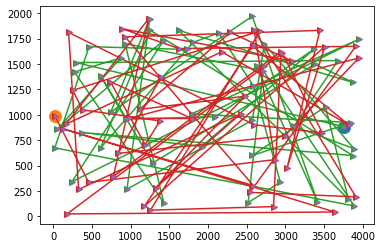

New best distance: 167954.3115716397
New best distance: 167073.8313165077
New best distance: 165636.0631505155
New best distance: 165062.49212106538
New best distance: 164385.7231705123
New best distance: 163926.2834021413
New best distance: 162326.74306469198
New best distance: 161981.25747200736
New best distance: 161699.4780285335
New best distance: 160941.62223019387
New best distance: 160121.8051664742
New best distance: 160008.88531926612
New best distance: 159980.7656112414
New best distance: 159832.01029599868
New best distance: 159437.36271000956
New best distance: 159414.2403924071
New best distance: 158461.3671488471
New best distance: 156932.16321476302
New best distance: 155986.06706300593
New best distance: 155781.76351027808
New best distance: 155206.47764552943
New best distance: 152742.2249600137
New best distance: 152460.72542250753
New best distance: 151924.73657422577
New best distance: 149144.619405261
New best distance: 147323.59465206345
New best distance: 147194

New best distance: 43340.22463442335
New best distance: 42904.04245379602
New best distance: 42419.16756753552
New best distance: 41979.807691578186
New best distance: 41763.76313210098
New best distance: 41563.39486110072
New best distance: 41221.59505888572
New best distance: 41143.66189023452
New best distance: 40974.650316267536
New best distance: 40723.227008843256
New best distance: 40682.148427501306
New best distance: 40340.06312156786
New best distance: 40311.345476593575
New best distance: 39695.72290750599
New best distance: 39413.91694757752
New best distance: 38382.95338502618
New best distance: 38323.777024784926
New best distance: 38280.541742294896
New best distance: 37920.70873673972
New best distance: 37541.34603761452
New best distance: 37517.902129078226
New best distance: 37268.07736671193
New best distance: 37081.96439382287
New best distance: 37063.71715529204
New best distance: 37026.97226854604
New best distance: 37014.76609170348
New best distance: 36875.72428

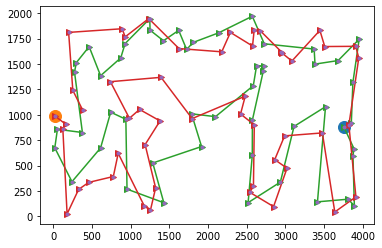

In [126]:
#MAIN - tu poskladac wyzej zaimplementowane funkcje w 8 roznych kombinacji algorytmow i sprawdzic ich czasy i wyplotowac skutecznosci

greedy_search(dista, np_kroa, True)

In [108]:
np.array(kroa)

array({1: (1380, 939), 2: (2848, 96), 3: (3510, 1671), 4: (457, 334), 5: (3888, 666), 6: (984, 965), 7: (2721, 1482), 8: (1286, 525), 9: (2716, 1432), 10: (738, 1325), 11: (1251, 1832), 12: (2728, 1698), 13: (3815, 169), 14: (3683, 1533), 15: (1247, 1945), 16: (123, 862), 17: (1234, 1946), 18: (252, 1240), 19: (611, 673), 20: (2576, 1676), 21: (928, 1700), 22: (53, 857), 23: (1807, 1711), 24: (274, 1420), 25: (2574, 946), 26: (178, 24), 27: (2678, 1825), 28: (1795, 962), 29: (3384, 1498), 30: (3520, 1079), 31: (1256, 61), 32: (1424, 1728), 33: (3913, 192), 34: (3085, 1528), 35: (2573, 1969), 36: (463, 1670), 37: (3875, 598), 38: (298, 1513), 39: (3479, 821), 40: (2542, 236), 41: (3955, 1743), 42: (1323, 280), 43: (3447, 1830), 44: (2936, 337), 45: (1621, 1830), 46: (3373, 1646), 47: (1393, 1368), 48: (3874, 1318), 49: (938, 955), 50: (3022, 474), 51: (2482, 1183), 52: (3854, 923), 53: (376, 825), 54: (2519, 135), 55: (2945, 1622), 56: (953, 268), 57: (2628, 1479), 58: (2097, 981), 59: 

In [100]:
start_cycle_random()

{0: array([64, 80,  4, 16, 81, 54, 43,  1, 30, 65, 93, 35, 29, 18, 37, 79, 68,
         5, 31, 55, 53, 15, 41, 10, 28,  7, 50, 21, 20, 99, 26, 59, 98, 22,
        77, 57, 36, 89, 63,  0, 24, 97, 32, 13, 88, 61, 96, 94,  9, 84]),
 1: array([70, 51, 72, 67, 87, 66, 14, 27, 38, 40, 52, 86, 92, 60, 83, 56, 49,
        34, 19, 74, 90, 70, 45, 39, 48, 73, 91,  6, 42, 23, 25, 95, 12, 62,
        75, 85, 44, 46, 58, 76, 78,  2, 33, 11,  8, 17, 82, 69,  3, 47])}

cycle[0]: 18111.064510714226
cycle[1]: 15269.30408454291


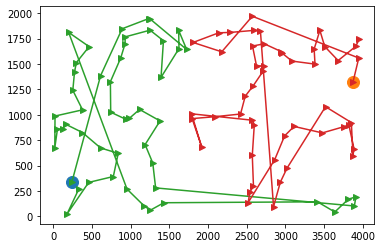

In [101]:
cycles = starty_cycle_heuristic()

In [58]:
x

array([0, 1, 2, 6, 5, 4, 3, 7, 8, 9])

In [59]:
change_edges(x, 5,5)

array([0, 1, 2, 6, 5, 4, 3, 7, 8, 9])

In [61]:
x = start_cycle_random()

In [64]:
len(x[1])

50

TypeError: Population must be a sequence or set.  For dicts, use list(d).

In [92]:
kroa

{1: (1380, 939),
 2: (2848, 96),
 3: (3510, 1671),
 4: (457, 334),
 5: (3888, 666),
 6: (984, 965),
 7: (2721, 1482),
 8: (1286, 525),
 9: (2716, 1432),
 10: (738, 1325),
 11: (1251, 1832),
 12: (2728, 1698),
 13: (3815, 169),
 14: (3683, 1533),
 15: (1247, 1945),
 16: (123, 862),
 17: (1234, 1946),
 18: (252, 1240),
 19: (611, 673),
 20: (2576, 1676),
 21: (928, 1700),
 22: (53, 857),
 23: (1807, 1711),
 24: (274, 1420),
 25: (2574, 946),
 26: (178, 24),
 27: (2678, 1825),
 28: (1795, 962),
 29: (3384, 1498),
 30: (3520, 1079),
 31: (1256, 61),
 32: (1424, 1728),
 33: (3913, 192),
 34: (3085, 1528),
 35: (2573, 1969),
 36: (463, 1670),
 37: (3875, 598),
 38: (298, 1513),
 39: (3479, 821),
 40: (2542, 236),
 41: (3955, 1743),
 42: (1323, 280),
 43: (3447, 1830),
 44: (2936, 337),
 45: (1621, 1830),
 46: (3373, 1646),
 47: (1393, 1368),
 48: (3874, 1318),
 49: (938, 955),
 50: (3022, 474),
 51: (2482, 1183),
 52: (3854, 923),
 53: (376, 825),
 54: (2519, 135),
 55: (2945, 1622),
 56: (9